<a href="https://colab.research.google.com/github/nayankote/YOLO_Object_Detection/blob/master/YoloCarDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf 
import numpy as np
from keras import backend as K
from keras.models import load_model, Model
from PIL import Image, ImageDraw, ImageFont
import scipy.io
from matplotlib.pyplot import imshow
import os
import colorsys
import random
import imageio

In [67]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def filter_boxes(box_confidence, boxes, box_class_probs, threshold):
  #box_confidence (19,19,5,1) -> pc is given 
  #boxes (19,19,5,4) -> bx,by,h,w is given
  #box_class_probs (19,19,5,80) -> the probabilities of the cell containing on of the 80 classes 
  #threshold -> the number by which the box_class_probs are filtered

  box_scores = box_confidence*box_class_probs # (19,19,5,80) gives Pc*Ci
  box_class = K.argmax(box_scores, axis = -1) # (19,19,5) gives which class has highest score for each of the 5 boxes
  box_class_score = K.max(box_scores, axis = -1) # (19,19,5) gives the highest score of the class for each of the 5 boxes
  print(box_class_score)
  
  mask = (box_class_score >= threshold) # (19,19,5) gives whether the highest score crosses the threshold
  print(mask)
  scores = tf.boolean_mask(box_class_score, mask, axis = None, name='scores') #(19,19,?)
  boxes = tf.boolean_mask(boxes, mask, axis=None, name='boxes') # (19,19,?,4)
  classes = tf.boolean_mask(box_class, mask, axis= None, name='classes') # (19,19,?)

  return scores, boxes, classes


In [0]:
def iou(box1,box2):
  (xu1,yu1),(xl1,yl1) = box1
  (xu2,yu2),(xl2,yl2) = box2

  xui = max(xu1,xu2)
  yui = max(yu1,yu2)
  xli = min(xl1,xl2)
  yli = min(yl1,yl2)

  inter_height = yli-yui
  inter_width = xli-xui
  inter_area = max(inter_height,0)*max(inter_width,0)

  box1_area = (xl1-xu1)*(yl1-yu1)
  box2_area = (xl2-xu2)*(yl2-yu2)
  total_area = box1_area + box2_area - inter_area

  iou = inter_area/total_area

  return iou

In [0]:
def non_max_suppression(boxes,scores,classes,max_boxes = 10, iou_threshold = 0.5):
  max_boxes_tensor = K.variable(max_boxes, dtype='int32')
  K.get_session().run(tf.variables_initializer([max_boxes_tensor]))

  nms_indices = tf.image.non_max_suppression(boxes,scores,max_boxes,iou_threshold,name='nms_indices')

  scores = K.gather(scores, nms_indices)
  boxes = K.gather(boxes, nms_indices)
  classes = K.gather(classes,nms_indices)

  return scores, boxes, classes

In [0]:
def boxes_to_corners(box_xy,box_wh):
    box_mins = box_xy - (box_wh / 2.)
    box_maxes = box_xy + (box_wh / 2.)

    return K.concatenate([
        box_mins[..., 1:2],  # y_min
        box_mins[..., 0:1],  # x_min
        box_maxes[..., 1:2],  # y_max
        box_maxes[..., 0:1]  # x_max
    ])
# I have no clue how the fuck this works

In [0]:
def scale_boxes(boxes,image_shape):
    height = image_shape[0]
    width = image_shape[1]
    image_dims = K.stack([height,width,height,width])
    image_dims = K.reshape(image_dims, [1,4])

    return boxes*image_dims

In [0]:
def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes=10, score_threshold=.6, iou_threshold=.5):

    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs
    boxes = boxes_to_corners(box_xy, box_wh)
    scores, boxes, classes = filter_boxes(box_confidence, boxes, box_class_probs, score_threshold)
    boxes = scale_boxes(boxes, image_shape)
    scores, boxes, classes = non_max_suppression(boxes,scores,classes,max_boxes = 10, iou_threshold = 0.5)

    return scores, boxes, classes

In [0]:
def read_anchors(path):
    with open(path) as f:
        anchors = f.readline()
        anchors = [float(x) for x in anchors.split(",")]
        anchors = np.array(anchors).reshape(-1,2)
    return anchors

def read_classes(path):
    with open(path) as f:
        classes = f.readlines()
    classes = [c.strip() for c in classes]
    return classes

In [0]:
def preprocess_image(path, model_image_size):
    image = Image.open(path)
    resized_image = image.resize(tuple(reversed(model_image_size)), Image.BICUBIC)
    image_data = np.array(resized_image, dtype='float32')
    image_data /= 255.
    image_data = np.expand_dims(image_data,0)
    return image, image_data

In [0]:
def draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors):
    font = ImageFont.truetype(font='/content/drive/My Drive/Colab Notebooks/Yolo Object Detection/FiraMono-Medium (2).otf', size=np.floor(3e-2*image.size[1]+0.5).astype('int32'))
    thickness = (image.size[0] + image.size[1])//300

    for i,c in reversed(list(enumerate(out_classes))):
        predicted_class = class_names[c]
        box = out_boxes[i]
        score = out_scores[i]

        label ='{} {:.2f}'.format(predicted_class,score)

        draw = ImageDraw.Draw(image)
        label_size = draw.textsize(label, font)

        top, left, bottom, right = box
        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
        right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
        print(label, (left, top), (right, bottom))

        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])
        else:
            text_origin = np.array([left, top + 1])

        # My kingdom for a good redistributable image drawing library.
        for i in range(thickness):
            draw.rectangle([left + i, top + i, right - i, bottom - i], outline=colors[c])
        draw.rectangle([tuple(text_origin), tuple(text_origin + label_size)], fill=colors[c])
        draw.text(text_origin, label, fill=(0, 0, 0), font=font)
        del draw
def generate_colors(class_names):
    hsv_tuples = [(x / len(class_names), 1., 1.) for x in range(len(class_names))]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))
    random.seed(10101)  # Fixed seed for consistent colors across runs.
    random.shuffle(colors)  # Shuffle colors to decorrelate adjacent classes.
    random.seed(None)  # Reset seed to default.
    return colors

In [0]:
'''def yolo_head(features, anchors, num_classes):
    num_anchors = len(anchors)
    anchors_tensor = K.reshape(K.variable(anchors), [1, 1, 1, num_anchors, 2]) #shape (1,1,1,5,2) batch,height,width,5 anchors, 2 dimensions
    conv_shape = K.shape(features)[1:3]

    height_tensor = K.arange(0, stop = conv_shape[0]) #basically forms a tesor of shape(n)
    width_tensor = K.arange(0, stop = conv_shape[1])
    height_tensor = K.tile(height_tensor, [conv_shape[1]]) #repeating the height tensor width number of times
    width_tensor = K.tile(K.expand_dims(width_tensor, 0), [conv_shape[0],1]) #add one dimension to width and replicate it height times
    width_tensor = K.flatten(K.transpose(width_tensor)) #not sure why we do this

    conv = K.transpose(K.stack([height_tensor,width_tensor]))
    conv = K.reshape(conv, [1, conv_shape[0], conv_shape[1], 1, 2])
    conv = K.cast(conv, K.dtype(features))

    festures = K.reshape(features, [-1, conv_shape[0], conv_shape[1], num_anchors, num_classes + 5])
    conv_shape = K.cast(K.reshape(conv_shape, [1, 1, 1, 1, 2]), K.dtype(features))

    box_confidence = K.sigmoid(features[..., 4:5])
    box_xy = K.sigmoid(features[..., :2])
    box_wh = K.exp(features[..., 2:4])
    box_class_probs = K.softmax(features[..., 5:])

    box_xy = (box_xy + conv)/conv_shape
    box_wh = box_wh * anchors_tensor / conv_shape

    return box_confidence, box_xy, box_wh, box_class_probs
'''

def yolo_head(feats, anchors, num_classes):


    num_anchors = len(anchors)
    # Reshape to batch, height, width, num_anchors, box_params.
    anchors_tensor = K.reshape(K.variable(anchors), [1, 1, 1, num_anchors, 2])
    # Static implementation for fixed models.
    # TODO: Remove or add option for static implementation.
    # _, conv_height, conv_width, _ = K.int_shape(feats)
    # conv_dims = K.variable([conv_width, conv_height])

    # Dynamic implementation of conv dims for fully convolutional model.
    conv_dims = K.shape(feats)[1:3]  # assuming channels last
    # In YOLO the height index is the inner most iteration.
    conv_height_index = K.arange(0, stop=conv_dims[0])
    conv_width_index = K.arange(0, stop=conv_dims[1])
    conv_height_index = K.tile(conv_height_index, [conv_dims[1]])

    # TODO: Repeat_elements and tf.split doesn't support dynamic splits.
    # conv_width_index = K.repeat_elements(conv_width_index, conv_dims[1], axis=0)
    conv_width_index = K.tile(K.expand_dims(conv_width_index, 0), [conv_dims[0], 1])
    conv_width_index = K.flatten(K.transpose(conv_width_index))
    conv_index = K.transpose(K.stack([conv_height_index, conv_width_index]))
    conv_index = K.reshape(conv_index, [1, conv_dims[0], conv_dims[1], 1, 2])
    conv_index = K.cast(conv_index, K.dtype(feats))
    
    feats = K.reshape(feats, [-1, conv_dims[0], conv_dims[1], num_anchors, num_classes + 5])
    conv_dims = K.cast(K.reshape(conv_dims, [1, 1, 1, 1, 2]), K.dtype(feats))

    # Static generation of conv_index:
    # conv_index = np.array([_ for _ in np.ndindex(conv_width, conv_height)])
    # conv_index = conv_index[:, [1, 0]]  # swap columns for YOLO ordering.
    # conv_index = K.variable(
    #     conv_index.reshape(1, conv_height, conv_width, 1, 2))
    # feats = Reshape(
    #     (conv_dims[0], conv_dims[1], num_anchors, num_classes + 5))(feats)

    box_confidence = K.sigmoid(feats[..., 4:5])
    box_xy = K.sigmoid(feats[..., :2])
    box_wh = K.exp(feats[..., 2:4])
    box_class_probs = K.softmax(feats[..., 5:])

    # Adjust preditions to each spatial grid point and anchor size.
    # Note: YOLO iterates over height index before width index.
    box_xy = (box_xy + conv_index) / conv_dims
    box_wh = box_wh * anchors_tensor / conv_dims

    return box_confidence, box_xy, box_wh, box_class_probs

In [78]:
anchors = read_anchors("/content/drive/My Drive/Colab Notebooks/Yolo Object Detection/anchors.txt")
class_names = read_classes("/content/drive/My Drive/Colab Notebooks/Yolo Object Detection/classes80.txt")
yolo_model = load_model("/content/drive/My Drive/Colab Notebooks/Yolo Object Detection/yolo.h5")
image_size = (720.,1080.)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [79]:
yolo_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 608, 608, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 608, 608, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [80]:
sess = K.get_session()
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))
scores, boxes, classes = yolo_eval(yolo_outputs)

Tensor("Max_2:0", shape=(?, ?, ?, 5), dtype=float32)
Tensor("GreaterEqual_2:0", shape=(?, ?, ?, 5), dtype=bool)


In [0]:
def predict(sess, image_file):
    image, image_data = preprocess_image("/content/drive/My Drive/Colab Notebooks/Yolo Object Detection/images/" + image_file, model_image_size = (608,608))
    out_scores, out_boxes, out_classes = sess.run(fetches = [scores,boxes,classes], feed_dict={yolo_model.input: image_data, K.learning_phase() : 0})
    print('Found {} boxes for {}'.format(len(out_boxes), image_file))
    colors = generate_colors(class_names)
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    image.save(os.path.join("/content/drive/My Drive/Colab Notebooks/Yolo Object Detection/out", image_file), quality=90)
    output_image = imageio.imread(os.path.join("/content/drive/My Drive/Colab Notebooks/Yolo Object Detection/out", image_file))
    imshow(output_image)
    return out_scores, out_boxes, out_classes

Found 7 boxes for test_yolo.jpg
car 0.60 (925, 285) (1045, 374)
car 0.66 (706, 279) (786, 350)
bus 0.67 (5, 266) (220, 407)
car 0.70 (947, 324) (1280, 705)
car 0.74 (159, 303) (346, 440)
car 0.80 (761, 282) (942, 412)
car 0.89 (367, 300) (745, 648)


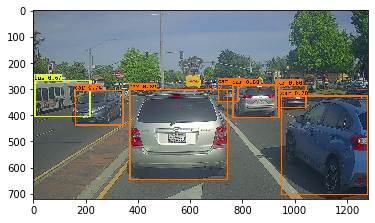

In [90]:
out_scores, out_boxes, out_classes = predict(sess, "test_yolo.jpg")

In [83]:
os.listdir()

['.config', 'drive', 'sample_data']